# The *pretty* training loop

### Imports and initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/MB_Grader

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MB_Grader


In [2]:
!pip install torch_geometric

In [3]:
import Batched_GNN_T5 as network

import numpy as np
import pandas as pd
import pickle
import random

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn

from collections import Counter
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch

# random.seed(7)
# torch.manual_seed(7)
# np.random.seed(7)

In [4]:
# PICKLE IN THE TRAIN AND TEST DATA
with open('Training_data/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('Training_data/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('Training_data/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('Training_data/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

with open('Training_data/global_graph.pkl', 'rb') as f:
    global_graph = pickle.load(f)

In [5]:
model = network.GNNClassifier(num_classes=11, global_graph=global_graph)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

def _init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.uniform_(m.weight, -0.05, 0.05)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(_init_weights)

Using device: cuda


GNNClassifier(
  (LNorm0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (LNorm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (LNorm2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  (LNorm3): LayerNorm((8192,), eps=1e-05, elementwise_affine=True)
  (coordinate_embedding_x): Embedding(11, 64)
  (coordinate_embedding_y): Embedding(18, 64)
  (coordinate_smoosh): Linear(in_features=128, out_features=64, bias=True)
  (position_embedding_1): Embedding(140, 64)
  (hold_type_one_hot_embedding): Linear(in_features=5, out_features=64, bias=True)
  (orientation_one_hot_embedding): Linear(in_features=8, out_features=64, bias=True)
  (feature_mix): Linear(in_features=256, out_features=256, bias=True)
  (edge_weights_1): Linear(in_features=384, out_features=1024, bias=True)
  (edge_weights_2): Linear(in_features=1024, out_features=256, bias=True)
  (conv1): GATv2Conv(256, 1024, heads=1)
  (conv2): GATv2Conv(1024, 4096, heads=1)
  (conv3): GATv2Conv(4096, 8192, head

### Class frequency normalization for training

In [6]:
# Should only be done on y_train
c = Counter(y_train)
class_counts = np.array([c[0], c[1], c[2], c[3], c[4], c[5], c[6], c[7], c[8], c[9], c[10]])
total_samples = sum(class_counts)

# Compute weights: Inverse class frequency
weights = total_samples / (len(class_counts) * class_counts) # + 1e1)
weights = torch.tensor(weights, dtype=torch.float32)

# Ensure it sums to 1 (optional normalization)
weights /= weights.sum()
weights



# Compute class weights (inverse frequency)
sample_weights = [weights[label] for label in y_train]  # dataset_labels = ground truth labels

# Convert to tensor
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

# Create a sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Convert y lists to tensors for training efficiency
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test , dtype=torch.long)

In [7]:
print(class_counts)
print(weights)
#weights = weights ** 0.2
print(weights)

# no epsilon
# [5944 2819  967  603  780  215   93   40    7    3    5] (+ 0 for weight calcs)
# tensor([2.3331e-04, 4.9194e-04, 1.4341e-03, 2.2998e-03, 1.7779e-03, 6.4502e-03,
#         1.4912e-02, 3.4670e-02, 1.9811e-01, 4.6226e-01, 2.7736e-01])

# epsolon = 50
# [5944 2819  967  603  780  215   93   40    7    3    5] (+ 50 for weight calcs)
# tensor([0.0005, 0.0010, 0.0028, 0.0045, 0.0035, 0.0125, 0.0280, 0.0614, 0.2369,
#         0.3625, 0.2865])

# epsolon = 100
# [5944 2819  967  603  780  215   93   40    7    3    5] (+ 100 for weight calcs)
# tensor([0.0007, 0.0014, 0.0040, 0.0064, 0.0050, 0.0175, 0.0384, 0.0799, 0.2438,
#         0.3245, 0.2784])

[5944 2819  967  603  780  215   93   40    7    3    5]
tensor([2.3331e-04, 4.9194e-04, 1.4341e-03, 2.2998e-03, 1.7779e-03, 6.4502e-03,
        1.4912e-02, 3.4670e-02, 1.9811e-01, 4.6226e-01, 2.7736e-01])
tensor([2.3331e-04, 4.9194e-04, 1.4341e-03, 2.2998e-03, 1.7779e-03, 6.4502e-03,
        1.4912e-02, 3.4670e-02, 1.9811e-01, 4.6226e-01, 2.7736e-01])


### Training loop functions

In [8]:
# Loop definition
def train(model, loaders, criterion, optimizer, drop_sched, num_epochs):
    accuracy_log = []
    train_set = loaders[0]
    train_set_eval = loaders[1]
    test_set = loaders[2]
    batch_size = train_set.batch_size

    for epoch in range(num_epochs):
        model.train()
        drop_sched.step()
        drop_coef = drop_sched.get_coef()
        #torch.autograd.set_detect_anomaly(False)

        for X_batch in train_set:
            X_batch = X_batch.to(device)
            old_params = [p.clone() for p in model.parameters()]

            optimizer.zero_grad()
            output = model(X_batch, drop_coef = drop_coef)
            loss = criterion(output, X_batch.y)
            loss.backward()
            optimizer.step()                    # Update weights
        scheduler.step()                        # Update LR
        #general_debugger(False)
        #in_loop_debugger?

        if epoch % 5 == 0:
            train_loss, train_accuracy, train_accuracy_leeway = test(model, train_set_eval)
            test_loss , test_accuracy , test_accuracy_leeway  = test(model, test_set)

            # Print the epoch stats
            print(f"Epoch [{epoch+1}/{num_epochs}], \n"
                  f"Train Loss: {train_loss:.6f}, "
                  f"Train Accuracy: {train_accuracy:.2f}%, "
                  f"Train Accuracy w leeway: {train_accuracy_leeway:.2f}%, \n"
                  f"Test  Loss: {test_loss:.6f}, "
                  f"Test  Accuracy: {test_accuracy:.2f}%, "
                  f"Test  Accuracy w leeway: {test_accuracy_leeway:.2f}% \n"
                  )
            accuracy_log.append([train_loss, train_accuracy, train_accuracy_leeway, test_loss, test_accuracy, test_accuracy_leeway])

    return accuracy_log

# Accuracy calculation for train or test
def test(model, data_loader):
    # Evaluate on the data_loader set
    model.eval()
    total = 0
    correct = 0
    correct_leeway = 0
    eval_loss = 0.0

    with torch.no_grad():
        for X_batch in data_loader:
            # Calculate and log the loss
            X_batch = X_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, X_batch.y)
            eval_loss += loss.item() * X_batch.num_graphs

            # Compare outputs to ground truths
            y_true = X_batch.y
            _, predicted = torch.max(output, dim=1)
            correct += (predicted == y_true).sum().item()
            correct_leeway += ((predicted >= y_true - 1) & (predicted <= y_true + 1)).sum().item()

            total += y_true.size(0)

    eval_loss = eval_loss / total
    accuracy = correct / total * 100
    accuracy_leeway = correct_leeway / total * 100

    return loss, accuracy, accuracy_leeway

# Debugger
def general_debug(debug):
    if debug == False:
      return False

    # debug = False
    # if debug:
    #     torch.autograd.set_detect_anomaly(True)
    #     print('batch shape:', X_batch)
    #     #print(X_batch.x[0])
    #     if index >= 10:
    #         raise

    # print("Grad norm for coord_y embedding:", model.coordinate_embedding_y.weight.grad.abs().mean().item())
    # print("Grad norm for coord_x embedding:", model.coordinate_embedding_x.weight.grad.abs().mean().item())
    # print("Grad norm for position embedding:", model.position_embedding_1.weight.grad.abs().mean().item())
    # print("Grad norm for one-hot hold_type linear:", model.hold_type_one_hot_embedding.weight.grad.abs().mean().item())
    # print("Grad norm for one-hot orientation linear:", model.orientation_one_hot_embedding.weight.grad.abs().mean().item())

    # print(X_batch)
    # print(X_batch.x[0])
    # print(loss)
    # for i, p in enumerate(model.parameters()):
    #     change = (p - old_params[i]).abs().sum()
    #     print(f"Parameter {i} changed by {change.item()}")

    return True

### Running the loop

In [9]:
# Hyperparameters and training objects

BATCH_SIZE = 64
NUM_EPOCHS = 81
LEARNING_RATE = 0.0005
# sched = lambda epoch: 0.5 if epoch>70 else (
#                       0.4 if epoch>25 else (
#                       0.3 if epoch>10 else
#                       epoch/20 ))
#sched = lambda epoch: min(0.5, epoch / 20)      # Basic scheduler
sched = lambda epoch: 0.3 if epoch>50 else 0.5   # Fine-tuning scheduler
BETAS = (0.9, 0.999)
EPS = 1e-8
WEIGHT_DECAY = 2e-4

train_loader      = DataLoader(X_train, batch_size = BATCH_SIZE, sampler=sampler)
train_loader_eval = DataLoader(X_train, batch_size = BATCH_SIZE)
test_loader       = DataLoader(X_test , batch_size = BATCH_SIZE)
loaders = [train_loader, train_loader_eval, test_loader]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, betas = BETAS, eps = EPS, weight_decay = WEIGHT_DECAY)
scheduler = LambdaLR(optimizer, lr_lambda = sched)

drop_sched = network.DropoutScheduler(NUM_EPOCHS, alpha = 1.5, beta = 0.9)
### maybe schedule dropout like LR, basically doing less then more then less. Let's the model get its footing and then makes it learn more general connections

In [10]:
# Training loop

model.load_state_dict(torch.load('Weights/gnn_T5_weights_thirdtry.pth', map_location=device))
train(model, loaders, criterion, optimizer, drop_sched, NUM_EPOCHS)
print()
torch.save(model.state_dict(), 'Weights/gnn_T5_weights_thirdtry_tuned.pth')

Epoch [1/81], 
Train Loss: 0.729282, Train Accuracy: 64.74%, Train Accuracy w leeway: 93.07%, 
Test  Loss: 0.834359, Test  Accuracy: 59.44%, Test  Accuracy w leeway: 88.50% 

Epoch [6/81], 
Train Loss: 0.634472, Train Accuracy: 69.09%, Train Accuracy w leeway: 95.26%, 
Test  Loss: 0.718547, Test  Accuracy: 63.41%, Test  Accuracy w leeway: 90.52% 

Epoch [11/81], 
Train Loss: 0.676722, Train Accuracy: 68.91%, Train Accuracy w leeway: 95.76%, 
Test  Loss: 0.812811, Test  Accuracy: 62.26%, Test  Accuracy w leeway: 90.63% 

Epoch [16/81], 
Train Loss: 0.752791, Train Accuracy: 66.58%, Train Accuracy w leeway: 94.41%, 
Test  Loss: 0.817311, Test  Accuracy: 61.18%, Test  Accuracy w leeway: 89.76% 

Epoch [21/81], 
Train Loss: 0.648305, Train Accuracy: 69.83%, Train Accuracy w leeway: 95.91%, 
Test  Loss: 0.826037, Test  Accuracy: 62.44%, Test  Accuracy w leeway: 90.91% 

Epoch [26/81], 
Train Loss: 0.713367, Train Accuracy: 69.77%, Train Accuracy w leeway: 95.24%, 
Test  Loss: 0.740930, Test

# Performance analysis

In [11]:
# count = 0
# for name, shape in model.named_parameters():
#   print(count, name)
#   count += 1

# # 25-34, 9-12

In [12]:
# for name, param in model.named_parameters():
#     print(f"{name}: mean={param.data.mean().item()}, std={param.data.std().item()}")

In [13]:
# #model(X_train[5].to(device)), y_train[5].to(device)
# for i in range(50):
#     print(model(X_train[i].to(device)), y_train[i].to(device))

In [14]:
test_loader_no_batch = DataLoader(X_test , batch_size=1)

right      = []
wrong_pred = []
wrong_true = []

right_lee  = []
wrong_leep = []
wrong_leet = []

all_x_pred = []
all_test_y = []

inc = 4
model.eval()
with torch.no_grad():
    for c in test_loader_no_batch:
        c = c.to(device)
        pred = model(c).data
        magnitude, index = torch.max(pred, 1)
        all_x_pred.append(index.item() + inc)
        all_test_y.append(c.y.item() + inc)
        if index == c.y:
            right.append(index.item() + inc)
        else:
            wrong_pred.append(index.item() + inc)
            wrong_true.append(c.y.item()   + inc)
        if (index >= c.y-1) and (index <= c.y+1):
            right_lee.append(index.item() + inc)
        else:
            wrong_leep.append(index.item() + inc)
            wrong_leet.append(c.y.item()   + inc)
        #print(index, c.y)


        # loss = criterion(output, y.unsqueeze(dim=0))
        #     test_loss += loss.item() #* batch_X.size(0)
        #     # Compute predictions
        #     _, predicted = torch.max(output.data, 1)

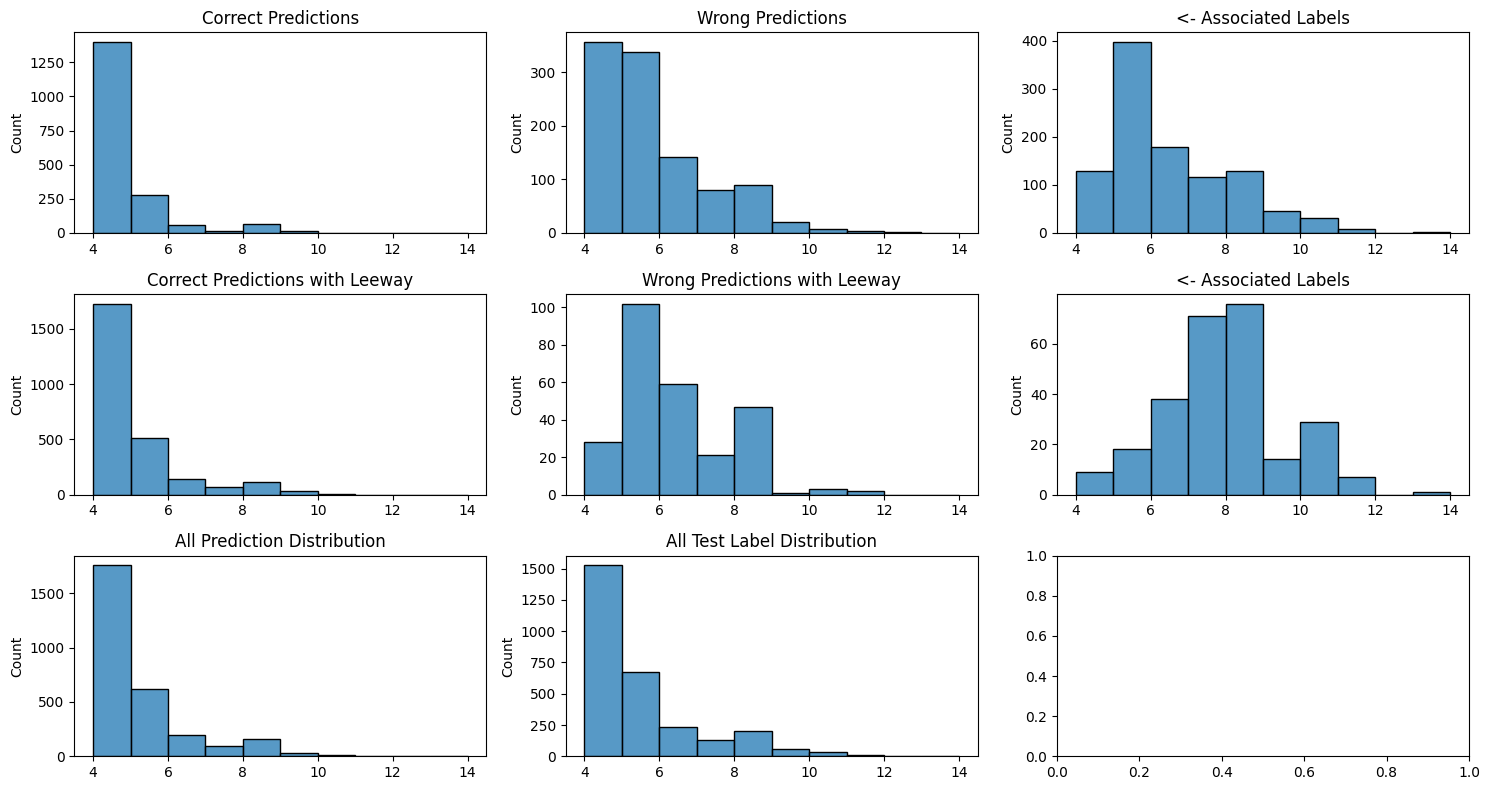

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
axes_list = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
#axes = axes.flatten()

sns.histplot(x = right     , bins = axes_list, ax = axes[0,0])
axes[0,0].set_title("Correct Predictions")

sns.histplot(x = wrong_pred, bins = axes_list, ax = axes[0,1])
axes[0,1].set_title("Wrong Predictions")

sns.histplot(x = wrong_true, bins = axes_list, ax = axes[0,2])
axes[0,2].set_title("<- Associated Labels")

sns.histplot(x = right_lee, bins = axes_list, ax = axes[1,0])
axes[1,0].set_title("Correct Predictions with Leeway")

sns.histplot(x = wrong_leep, bins = axes_list, ax = axes[1,1])
axes[1,1].set_title("Wrong Predictions with Leeway")

sns.histplot(x = wrong_leet, bins = axes_list, ax = axes[1,2])
axes[1,2].set_title("<- Associated Labels")

sns.histplot(x = all_x_pred, bins = axes_list, ax = axes[2,0])
axes[2,0].set_title("All Prediction Distribution")

sns.histplot(x = all_test_y, bins = axes_list, ax = axes[2,1])
axes[2,1].set_title("All Test Label Distribution")

#axes[1,1].set_visible(False)

plt.tight_layout()
plt.show()